# Normalizing Flows

Normalizing flows are an exciting technique to transform a known probability density, say the Normal distribution, into a more complex one that is e.g. observed from some data. This is achieved by applying a sequence of invertible transformations $t_1, \ldots t_n$. By doing this, we gain two things:

* **We can easily sample from the complex distribution.** Let $X \sim p$ be a random variable obtained from the known probability density, we can easily obtain a sample $Z \sim q$ from the complex distribution by applying the transformations:

\begin{equation}
Z = (t_1 \circ \cdots \circ t_n)(X)
\end{equation}

* **We can easily evaluate the probability of a sample observed for the complex distribution.** Let $Z \sim q$ be a sample from the complex distribution and $p$ be the probability density function of the known distribution, then we can simply apply the inverse transformations (we will discuss the normalization of this probability density further down below):

\begin{equation}
q(Z) \propto p\left(\left(t_n^{-1} \circ \cdots \circ t_1^{-1}\right)(Z)\right)
\end{equation}

The goal of this tutorial is to provide some intuition about the behavior of normalizing flows. For this, we make use of [PyTorch](https://pytorch.org) and a higher-level library, [PyBlaze](https://pyblaze.borchero.com).

Normalizing flows were introduced by Rezende and Mohamed in their paper [Variational Inference with Normalizing Flows](https://arxiv.org/pdf/1505.05770.pdf) (2015).

## Data

In [1]:
import sklearn.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import pyblaze.nn as xnn
import pyblaze.plot as P
import matplotlib.pyplot as plt

plt.style.use('seaborn-notebook')
plt.rcParams['figure.dpi'] = 150

In [2]:
data_unicluster = datasets.make_biclusters((4096, 2), 1, noise=0.3, minval=-2, maxval=2, random_state=17)[0]
data_tricluster = datasets.make_biclusters((4096, 2), 3, noise=0.1, minval=-2, maxval=2, random_state=14)[0]
data_moons = datasets.make_moons(4096, noise=0.05)[0]

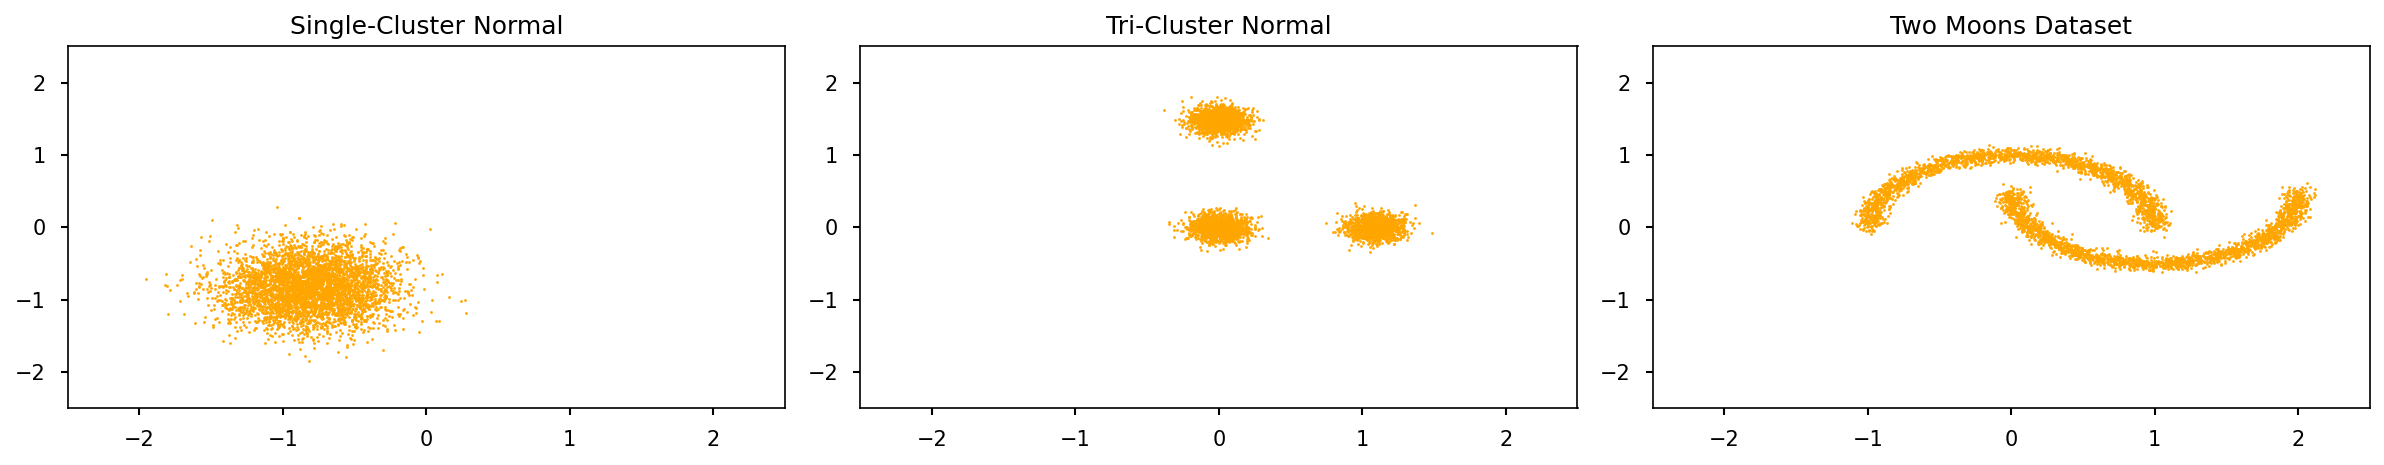

In [3]:
plt.figure(figsize=plt.figaspect(0.2))

plt.subplot(1, 3, 1)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.scatter(*data_unicluster.T, s=1, color='orange')
plt.title('Single-Cluster Normal')

plt.subplot(1, 3, 2)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.scatter(*data_tricluster.T, s=1, color='orange')
plt.title('Tri-Cluster Normal')

plt.subplot(1, 3, 3)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.scatter(*data_moons.T, s=1, color='orange')
plt.title('Two Moons Dataset')

plt.tight_layout()
plt.show()

In [30]:
def train(engine, data):
    data_ = torch.as_tensor(data, dtype=torch.float)
    loader = TensorDataset(data_).loader(batch_size=4096)
    
    optimizer = optim.Adam(engine.model.parameters(), lr=1e-3)

    return engine.train(
        loader,
        epochs=1000,
        optimizer=optimizer,
        loss=xnn.TransformedNormalLoss(),
        callbacks=[
            xnn.EpochProgressLogger(),
        ],
        gpu=False
    )

In [5]:
def train_and_plot_for_all(engine):
    plt.figure(figsize=plt.figaspect(0.2))
    loss = xnn.TransformedNormalLoss(reduction='none')

    print("Dataset (1/3)...")
    train(engine, data_unicluster)
    plt.subplot(1, 3, 1)
    P.density_plot2d(lambda x: -loss(*engine.model(x)), (-2.5, 2.5), (-2.5, 2.5), cmap='Blues')
    plt.colorbar()
    plt.scatter(*data_unicluster.T, s=3, color='orange', alpha=0.1)

    print("Dataset (2/3)...")
    train(engine, data_tricluster)
    plt.subplot(1, 3, 2)
    P.density_plot2d(lambda x: -loss(*engine.model(x)), (-2.5, 2.5), (-2.5, 2.5), cmap='Blues')
    plt.colorbar()
    plt.scatter(*data_tricluster.T, s=3, color='orange', alpha=0.1)

    print("Dataset (3/3)...")
    train(engine, data_moons)
    plt.subplot(1, 3, 3)
    P.density_plot2d(lambda x: -loss(*engine.model(x)), (-2.5, 2.5), (-2.5, 2.5), cmap='Blues')
    plt.colorbar()
    plt.scatter(*data_moons.T, s=3, color='orange', alpha=0.1)

    plt.show()

## Transformations

...

$f: \mathbb{R}^D \rightarrow \mathbb{R}^D$

### Affine Transform

The affine transform is the simplest kind of transformation as it simply scales and shifts the input variable. For the input $\mathbf{z} \in \mathbb{R}^D$, it is defined as

\begin{equation}
    f_{\mathbf{\alpha}, \beta}(\mathbf{z}) = \mathbf{\alpha} \odot \mathbf{z} + \beta \qquad \qquad \mathbf{\alpha} \in \mathbb{R}^D, \beta \in \mathbb{R}
\end{equation}

Given this transformation, we can take away the following:

* The affine transform is invertible for all $\mathbf{y} \in \mathbb{R}$.
* Chaining multiple affine transforms is redundant. The parameters of the chained transforms can be absorbed into a single transform.
* By applying the affine transform, the shape of the transformed distribution never changes.

In order to get more intuition for this transformation, we fit a normalizing flow using a single affine transform to the datasets we defined above.

First, we define a model for 2-dimensional inputs:

In [25]:
affine_model = xnn.NormalizingFlow([xnn.AffineTransform(2)])

Then we can initialize an engine. For the engine we choose the `LikelihoodEngine` which assumes that the trained model outputs log-probabilities for the inputs. It then optimizes the parameters by minimizing the negative log-likelihood.

In [26]:
affine_engine = xnn.MLEEngine(affine_model, expects_data_target=False)

Eventually, we run training using the `train` helper function defined above for each of our datasets. For each dataset, we visualize the distribution learnt by our normalizing flow:

Dataset (1/3)...
 [Elapsed 0:00:33]                                                      
Dataset (2/3)...
 [Elapsed 0:00:31]                                                      
Dataset (3/3)...
 [Elapsed 0:00:30]                                                      


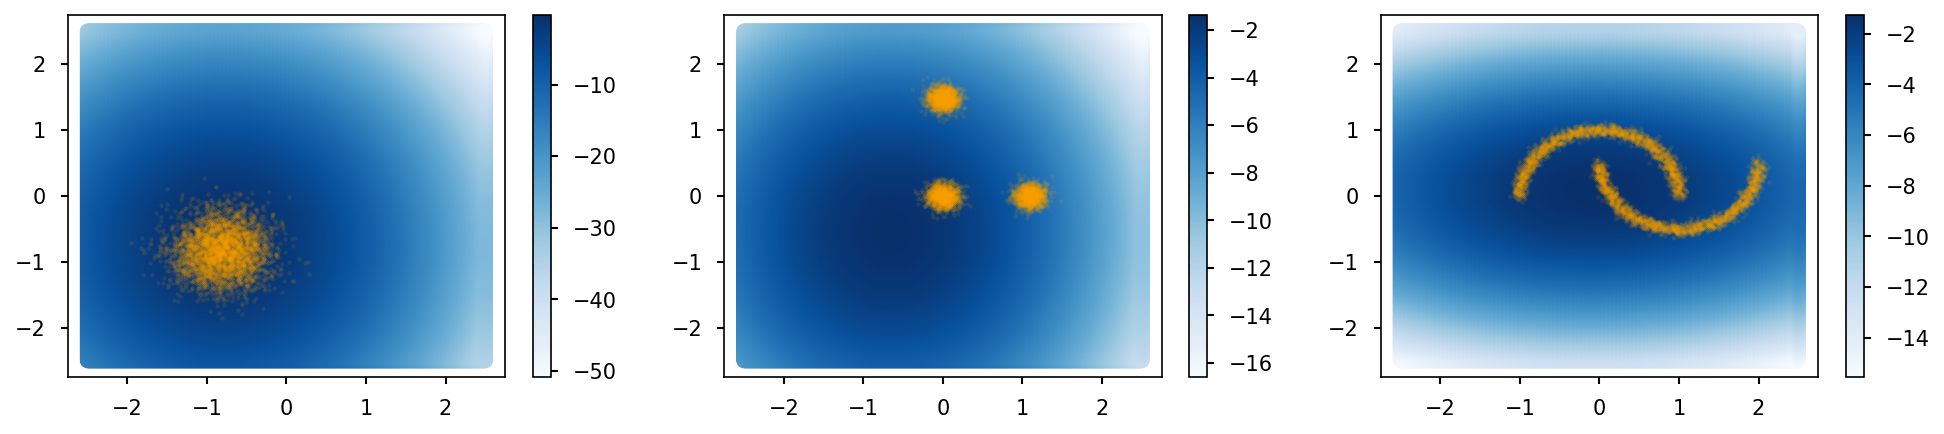

In [27]:
train_and_plot_for_all(affine_engine)

As we can see (and could expect), the affine transform is able to match the distribution of our single-cluster Normal. As the probabilities of the normalizing flow are evaluated for a standard Normal, the affine transform simply needs to scale and shift the dataset.

For the other two datasets, the affine transform fails. Scaling and shifting is unsifficient to split up the Normal distribution.

### Radial Transform

In [39]:
radial_model = xnn.NormalizingFlow([xnn.RadialTransform(2) for _ in range(32)])

In [40]:
radial_engine = xnn.MLEEngine(radial_model, expects_data_target=False)

In [ ]:
train_and_plot_for_all(radial_engine)

In [41]:
train(radial_engine, data_moons)

 [Elapsed 0:01:20]                                                      


History<['batch_loss', 'loss']>

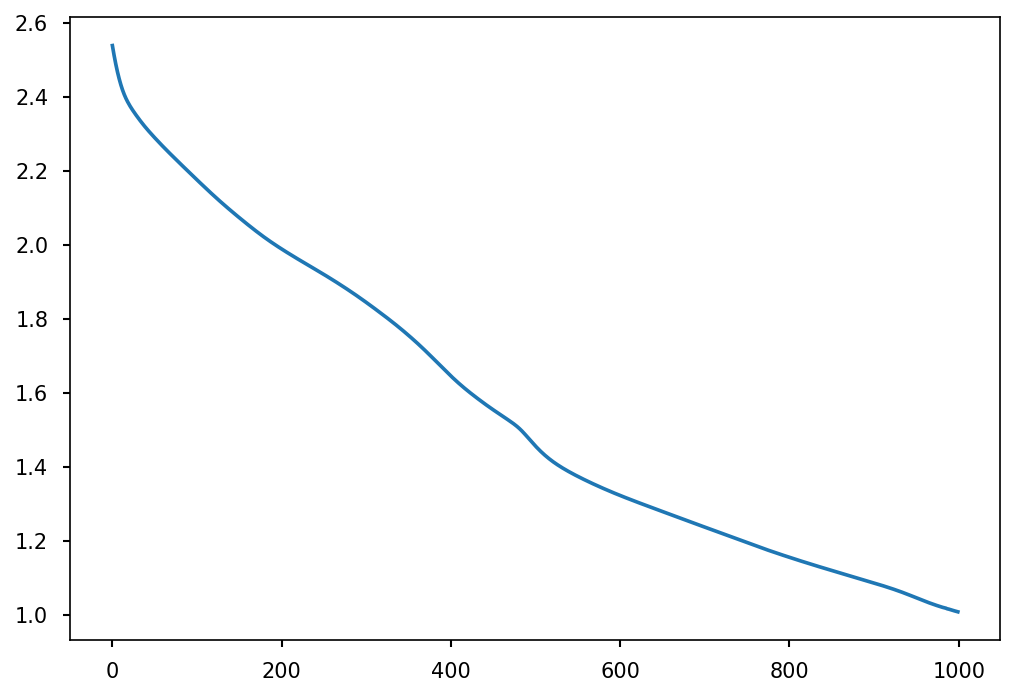

In [44]:
plt.figure()
plt.plot(range(len(_41.loss)), _41.loss)
plt.show()

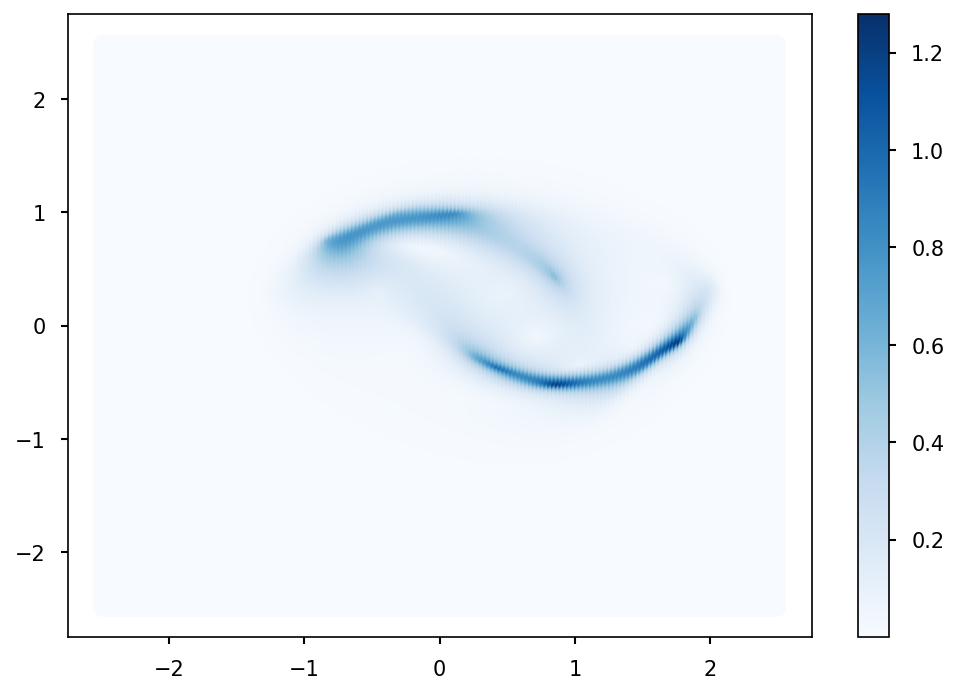

In [43]:
loss = xnn.TransformedNormalLoss(reduction='none')
plt.figure()
P.density_plot2d(lambda x: (-loss(*radial_engine.model(x))).exp(), (-2.5, 2.5), (-2.5, 2.5), cmap='Blues')
plt.colorbar()
# plt.scatter(*data_moons.T, s=3, color='orange', alpha=0.1)
plt.show()

### Affine Coupling

In [31]:
class NN(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.mean = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_dim)
        )
        self.logvar = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_dim)
        )
        
    def forward(self, x):
        return self.mean(x), self.logvar(x)

In [32]:
affine_coupling_model = xnn.NormalizingFlow([
    xnn.AffineCouplingTransform(2, 1, NN(1, 1), reverse=False),
    xnn.AffineCouplingTransform(2, 1, NN(1, 1), reverse=True),
    xnn.AffineCouplingTransform(2, 1, NN(1, 1), reverse=False),
    xnn.AffineCouplingTransform(2, 1, NN(1, 1), reverse=True),
])

In [33]:
affine_coupling_engine = xnn.MLEEngine(affine_coupling_model, expects_data_target=False)

In [34]:
history = train(affine_coupling_engine, data_moons)

 [Elapsed 0:00:51]                                                      


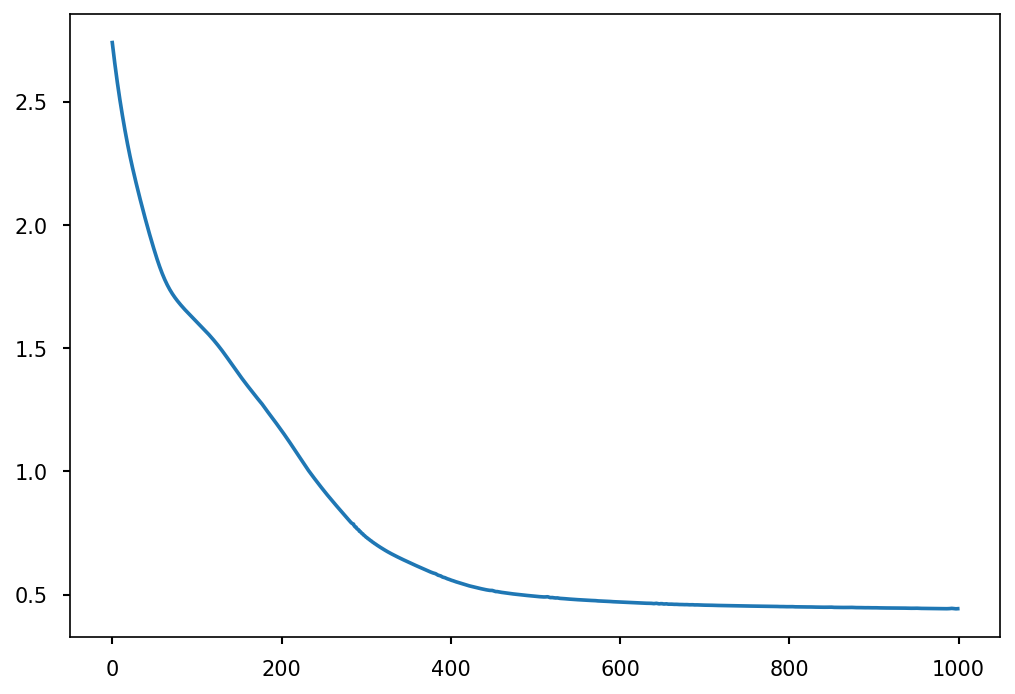

In [35]:
plt.figure()
plt.plot(range(len(history.loss)), history.loss)
plt.show()

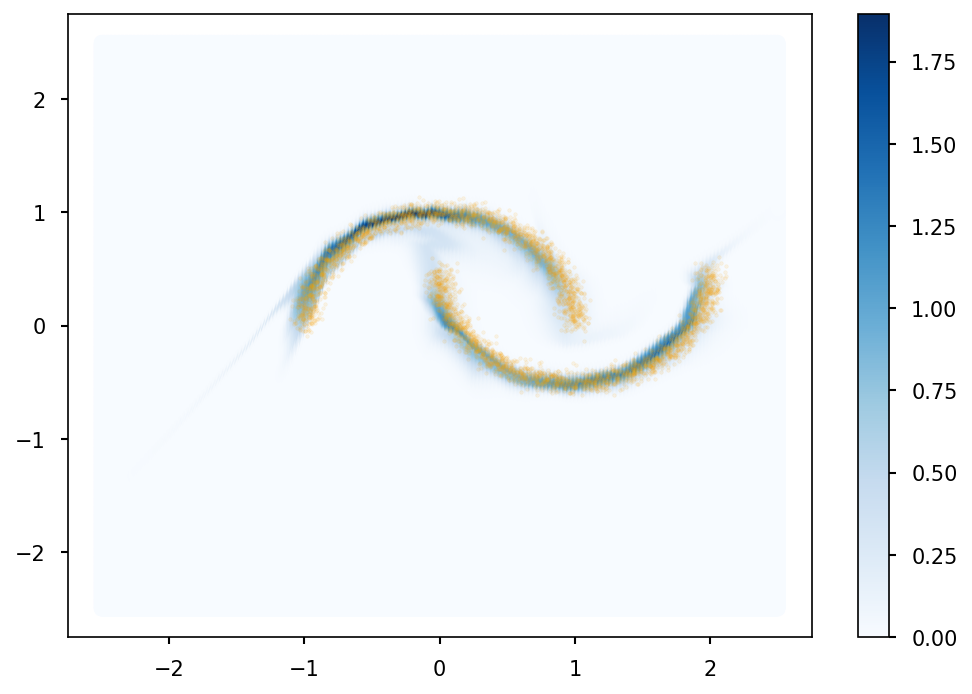

In [38]:
loss = xnn.TransformedNormalLoss(reduction='none')
plt.figure()
P.density_plot2d(lambda x: (-loss(*affine_coupling_model(x))).exp(), (-2.5, 2.5), (-2.5, 2.5), cmap='Blues')
plt.colorbar()
plt.scatter(*data_moons.T, s=3, color='orange', alpha=0.1)
plt.show()